In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [4]:
import fastai
print(fastai.__version__)

1.0.39.dev0


In [5]:
torch.cuda.set_device(0)

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
%xmode Pain

/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/IPython/core/magics/basic.py:372: UserWarning: Error changing user exception modes.
Unrecognized mode in FormattedTB: <Pain>
Valid modes: ['Plain', 'Context', 'Verbose', 'Minimal']
  (name,sys.exc_info()[1]))


# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [9]:
path = Path('../data/rossmann/')
train_df = pd.read_pickle(path/'train_clean')

In [10]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [11]:
n = len(train_df); n

844338

### Preparing full data set

In [12]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [13]:
len(train_df),len(test_df)

(844338, 41088)

In [14]:
procs=[FillMissing, Categorify, Normalize]

In [15]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [16]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [17]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [18]:
len(test_df)

41088

In [19]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [20]:
valid_idx = range(cut)

In [21]:
val_df = df.iloc[valid_idx]


In [22]:
#check validation dataframe for data not in train df
def check_val_df():
    print('checking val vs df classes')
    col_diffs={}
    for col in df:
        #new set with elements in val_df but not in df
        diffs = set(val_df[col]).difference(set(df[col]))
        print(f'col: {col}, diffs: {len(diffs)}')
        if len(diffs)>0:
            col_diffs[col]=diffs
    return col_diffs

In [23]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [24]:
def unique_deps(x:Series)->List:
    od = OrderedDict.fromkeys(x)
    res = list(OrderedDict.fromkeys(x).keys())
    res.sort()
    return res, od

In [25]:
classes, od =unique_deps(df[dep_var].values)

In [26]:
#classes

In [27]:
#data = TabularDataBunch.from_df(path, df=df, dep_var=dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_vars, cont_names=cont_vars, classes=classes, test_df=test_df)

In [28]:
#error at predict
#data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs, test_df=test_df) .split_by_idx(valid_idx) .label_from_df(cols=dep_var, label_cls=FloatList, log=True, classes=classes) .databunch())

In [29]:
#error on predict
#data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs, test_df=test_df)
#                   .split_by_idx(valid_idx)
#                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
#                   .databunch())

In [30]:
#original method
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs, test_df=test_df)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

--label_from_df() cols: Sales
--label_from_df() cols: Sales


## Model

In [31]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [32]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [33]:
#learn.model

In [34]:
len(data.train_ds.cont_names)

16

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


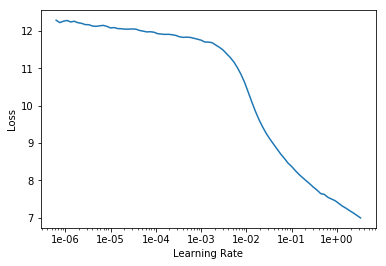

In [36]:
learn.recorder.plot()

In [37]:
#minimum at 1.0 to 3.0

In [38]:
learn.fit_one_cycle(3, 3e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.082346,0.049819,0.230757
2,0.049155,0.092997,0.378857
3,0.017168,0.014459,0.117964


In [39]:
learn.save('1_tabularlist')

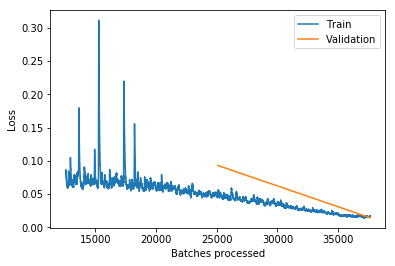

In [40]:
learn.recorder.plot_losses(last=-1)

In [41]:
#learn.load('1');

In [42]:
#learn.fit_one_cycle(5, 3e-4)

In [43]:
#learn.fit_one_cycle(5, 3e-4)

(10th place in the competition was 0.108)

## Predict

In [44]:
preds, y = learn.get_preds(DatasetType.Test)

TypeError: object of type 'NoneType' has no len()

### Test 2

using:

data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs, test_df=test_df)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True, classes=classes)
                   .databunch())

<pre>
/mnt/963GB/Data/Python/Courses/fastai/fastai/fastai/basic_train.py in get_preds(model=TabularModel(
  (embeds): ModuleList(
    (0): E...in_features=500, out_features=1, bias=True)
  )
), dl=None, pbar=None, cb_handler=CallbackHandler(callbacks=[], metrics=[], beta=0.98), activ=<function noop>, loss_func=None, n_batch=None)
     36     "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
     37     res = [torch.cat(o).cpu() for o in
---> 38            zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]
        global zip = undefined
        global validate = <function validate at 0x7fa15a3e9598>
        model = TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)
        dl = None
        cb_handler = CallbackHandler(callbacks=[], metrics=[], beta=0.98)
        pbar = None
        global average = undefined
        n_batch = None
     39     if loss_func is not None: res.append(calc_loss(res[0], res[1], loss_func))
     40     if activ is not None: res[0] = activ(res[0])

/mnt/963GB/Data/Python/Courses/fastai/fastai/fastai/basic_train.py in validate(model=TabularModel(
  (embeds): ModuleList(
    (0): E...in_features=500, out_features=1, bias=True)
  )
), dl=None, loss_func=None, cb_handler=CallbackHandler(callbacks=[], metrics=[], beta=0.98), pbar=None, average=False, n_batch=None)
     47     with torch.no_grad():
     48         val_losses,nums = [],[]
---> 49         for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
        xb = undefined
        yb = undefined
        global progress_bar = <class 'fastprogress.fastprogress.NBProgressBar'>
        dl = None
        global parent = undefined
        pbar = None
        global leave = undefined
     50             if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
     51             val_losses.append(loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler))

~/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/fastprogress/fastprogress.py in __init__(self=<fastprogress.fastprogress.NBProgressBar object>, gen=None, total=None, display=True, leave=False, parent=None, auto_update=True)
    143 class NBProgressBar(ProgressBar):
    144     def __init__(self, gen, total=None, display=True, leave=True, parent=None, auto_update=True):
--> 145         self.progress = html_progress_bar(0, len(gen) if total is None else total, "")
        self.progress = undefined
        global html_progress_bar = <function html_progress_bar at 0x7fa1918fb840>
        global len = undefined
        gen = None
        total = None
    146         super().__init__(gen, total, display, leave, parent, auto_update)
    147 

TypeError: object of type 'NoneType' has no len()
</pre>

ipdb> gen.shape
*** AttributeError: 'NoneType' object has no attribute 'shape'

### Test N

using: 

data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs, test_df=test_df)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())
    
<pre>
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-41-e2910b925ecd> in <module>
----> 1 preds, y = learn.get_preds(DatasetType.Test)

/mnt/963GB/Data/Python/Courses/fastai/fastai/fastai/basic_train.py in get_preds(self, ds_type, with_loss, n_batch, pbar)
    228         lf = self.loss_func if with_loss else None
    229         return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(self.callbacks),
--> 230                          activ=_loss_func2activ(self.loss_func), loss_func=lf, n_batch=n_batch, pbar=pbar)
    231 
    232     def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False) -> List[Tensor]:

/mnt/963GB/Data/Python/Courses/fastai/fastai/fastai/basic_train.py in get_preds(model, dl, pbar, cb_handler, activ, loss_func, n_batch)
     36     "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
     37     res = [torch.cat(o).cpu() for o in
---> 38            zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]
     39     if loss_func is not None: res.append(calc_loss(res[0], res[1], loss_func))
     40     if activ is not None: res[0] = activ(res[0])

/mnt/963GB/Data/Python/Courses/fastai/fastai/fastai/basic_train.py in validate(model, dl, loss_func, cb_handler, pbar, average, n_batch)
     47     with torch.no_grad():
     48         val_losses,nums = [],[]
---> 49         for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
     50             if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
     51             val_losses.append(loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler))

~/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/fastprogress/fastprogress.py in __init__(self, gen, total, display, leave, parent, auto_update)
    143 class NBProgressBar(ProgressBar):
    144     def __init__(self, gen, total=None, display=True, leave=True, parent=None, auto_update=True):
--> 145         self.progress = html_progress_bar(0, len(gen) if total is None else total, "")
    146         super().__init__(gen, total, display, leave, parent, auto_update)
    147 

TypeError: object of type 'NoneType' has no len()

</pre>

In [ ]:
%debug

In [ ]:
probs = np.exp(preds)

In [ ]:
#get classes
d = {}
p = {}
i=0
for indx, prob in zip(indexes, probs):
    if i==0:
        print(f'prob: {prob}, dim: {prob.shape}, indx: {indx}')
    max_idx = np.argmax(prob)
    max_val = prob[max_idx].item()
    p[indx] = max_val
    prob_c = classes[max_idx]
    d[indx] = prob_c

In [ ]:
len(d)

In [ ]:
def pred_serial():
    preds = {}
    for idx, row in test_df.iterrows():
        pred = learn.predict(row)
        pred_str = pred[0].__str__()
        preds[idx]=pred_str
        if int(idx) % 10000 == 0:
            print(f'pred: {pred}, idx: {idx}')
    return preds

In [ ]:
preds_d = pred_serial()